In [2]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
directory = "C:/Users/tokud/Projects/Insurance Linear Regression/best_model.pkl"

best_model = joblib.load(directory)
best_model

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.01
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [4]:
path = "C:/Users/tokud/Projects/Insurance Linear Regression/transactions.csv"

df = pd.read_csv(path)
print(df.shape)
df.head()

(100000, 5)


,transaction_id,product_type,region,amount,transaction_date
0,1,Renters,West,21.52,2024-01-21
1,2,Renters,Northeast,12.76,2024-03-28
2,3,Renters,Northeast,20.46,2024-11-04
3,4,Flood,South,91.27,2024-07-10
4,5,Flood,South,197.09,2024-09-09


In [7]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

df['month_index'] = (
    (df['transaction_date'].dt.year - df['transaction_date'].dt.year.min()) * 12
    + df['transaction_date'].dt.month
)

In [9]:
df_regions = (
    df.groupby(['month_index', 'region'])['amount']
    .sum()
    .reset_index()
    .sort_values(['month_index', 'region'])
)

df_regions

,month_index,region,amount
0,1,Midwest,46862.04
1,1,Northeast,50118.97
2,1,South,108993.79
3,1,West,52388.05
4,2,Midwest,43848.31
...,...,...,...
79,20,West,50195.14
80,21,Midwest,44856.40
81,21,Northeast,43251.54
82,21,South,92088.75


In [11]:
forecasts = []

for region, group in df_regions.groupby('region'):
    X = group['month_index'].values.reshape(-1, 1)
    y = group['amount'].values
    
    best_model.fit(X, y)
    
    next_months = [[22], [23], [24]]
    
    predictions = best_model.predict(next_months)
    
    forecast_total = predictions.sum()
    
    forecasts.append({
        'region': region,
        'forecast_Q42025': round(forecast_total, 2)
    })
    
df_forecast = pd.DataFrame(forecasts)
df_forecast = df_forecast.sort_values('forecast_Q42025', ascending=False)
df_forecast

,region,forecast_Q42025
2,South,303298.00
3,West,156882.90
0,Midwest,132480.29
1,Northeast,123367.09


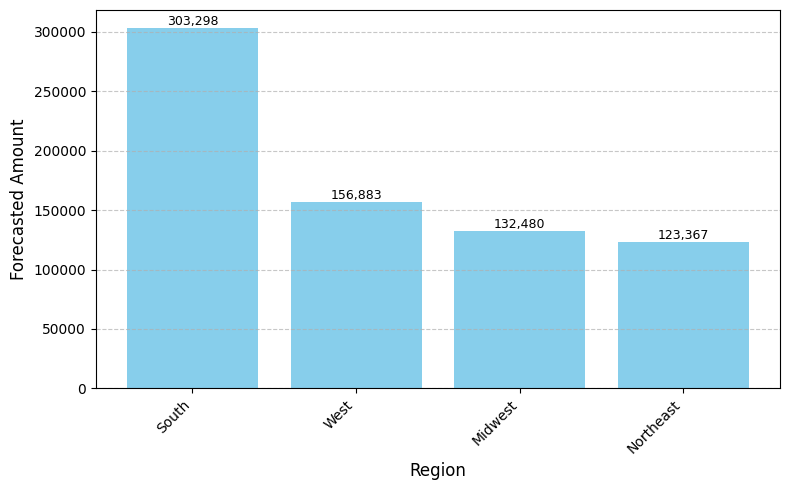

In [12]:
plt.figure(figsize=(8,5))
plt.bar(df_forecast['region'], df_forecast['forecast_Q42025'], color='skyblue')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Forecasted Amount', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)

for index, value in enumerate(df_forecast['forecast_Q42025']):
    plt.text(index, value, f"{round(value, 0):,.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

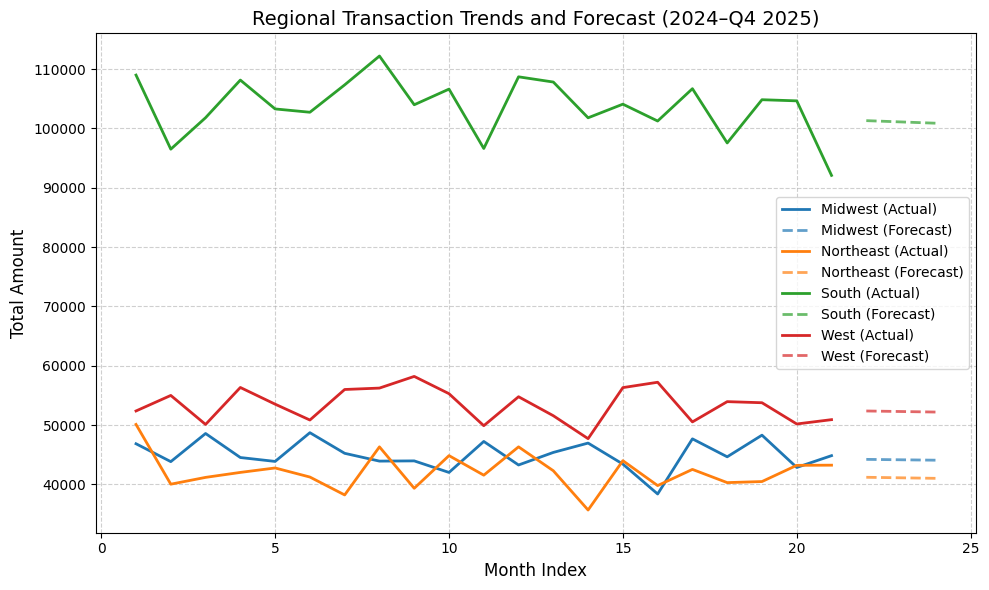

In [13]:
forecast_rows = []

for region, group in df_regions.groupby('region'):
    X = group['month_index'].values.reshape(-1, 1)
    y = group['amount'].values

    best_model.fit(X, y)

    # Forecast months 22, 23, 24 (Oct, Nov, Dec 2025)
    next_months = np.array([[22], [23], [24]])
    predictions = best_model.predict(next_months)

    for m, pred in zip([22, 23, 24], predictions):
        forecast_rows.append({
            'region': region,
            'month_index': m,
            'amount': pred,
            'type': 'forecast'
        })

df_forecast_extended = pd.DataFrame(forecast_rows)

df_actual_extended = df_regions.copy()
df_actual_extended['type'] = 'actual'

df_combined = pd.concat([df_actual_extended, df_forecast_extended], ignore_index=True)

plt.figure(figsize=(10, 6))

regions = df_combined['region'].unique()
colors = plt.cm.tab10.colors

for i, region in enumerate(regions):
    region_data = df_combined[df_combined['region'] == region]
    actual_data = region_data[region_data['type'] == 'actual']
    forecast_data = region_data[region_data['type'] == 'forecast']

    plt.plot(actual_data['month_index'], actual_data['amount'],
             label=f"{region} (Actual)", color=colors[i], linewidth=2)

    plt.plot(forecast_data['month_index'], forecast_data['amount'],
             linestyle='--', color=colors[i], linewidth=2, alpha=0.7,
             label=f"{region} (Forecast)")

plt.title('Regional Transaction Trends and Forecast (2024–Q4 2025)', fontsize=14)
plt.xlabel('Month Index', fontsize=12)
plt.ylabel('Total Amount', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
df.columns

Index(['transaction_id', 'product_type', 'region', 'amount',
       'transaction_date', 'month_index'],
      dtype='object')

In [15]:
df_product = (
    df.groupby(['month_index', 'product_type', 'region'])['amount']
    .sum()
    .reset_index()
    .sort_values(['month_index', 'product_type', 'region'])
)

df_product

,month_index,product_type,region,amount
0,1,Flood,Midwest,5349.07
1,1,Flood,Northeast,6045.95
2,1,Flood,South,26116.28
3,1,Flood,West,4063.17
4,1,Homeowners,Midwest,29202.48
...,...,...,...,...
247,21,Homeowners,West,29588.77
248,21,Renters,Midwest,12638.41
249,21,Renters,Northeast,13183.18
250,21,Renters,South,25965.76


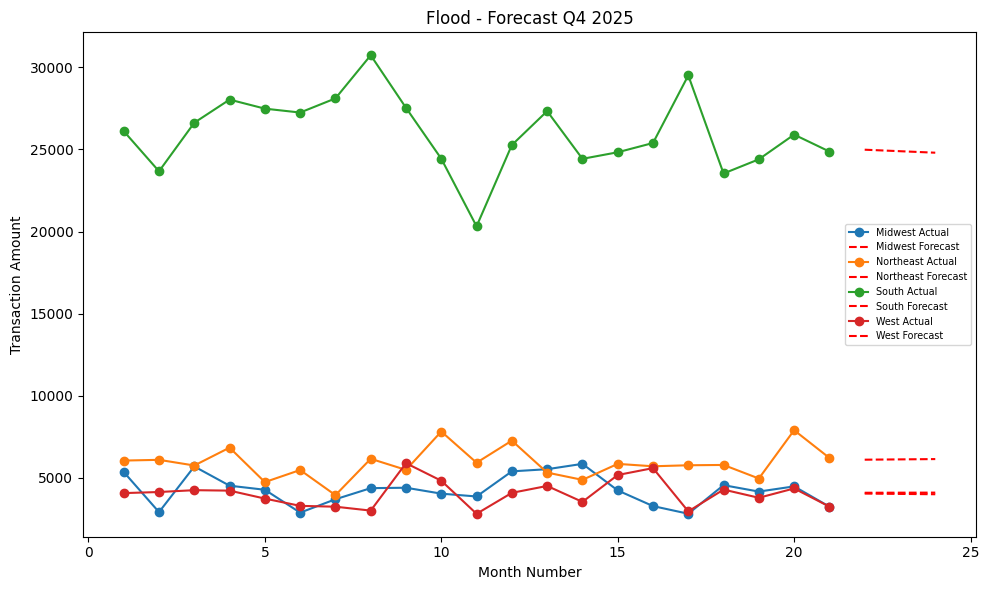

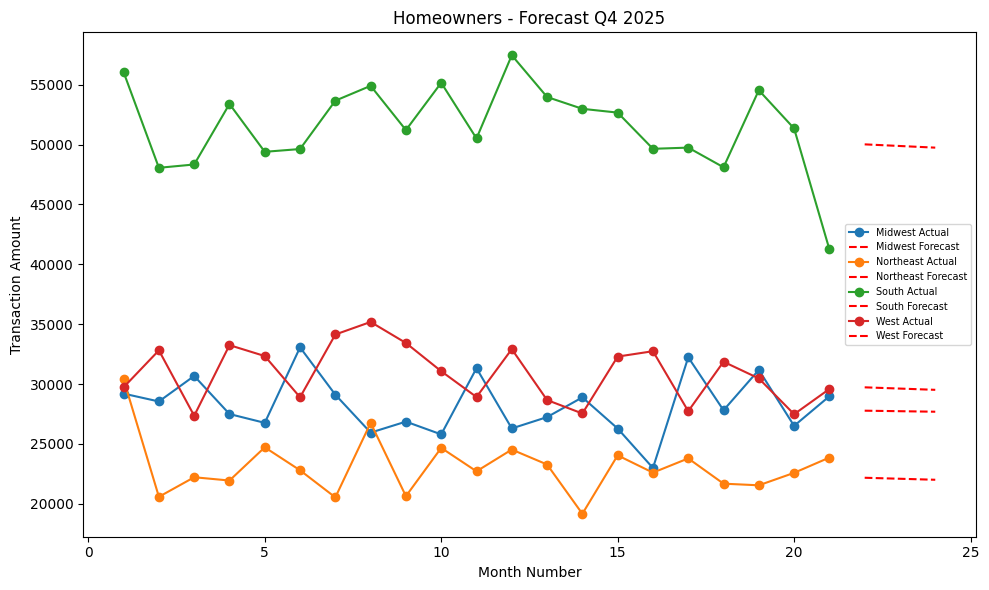

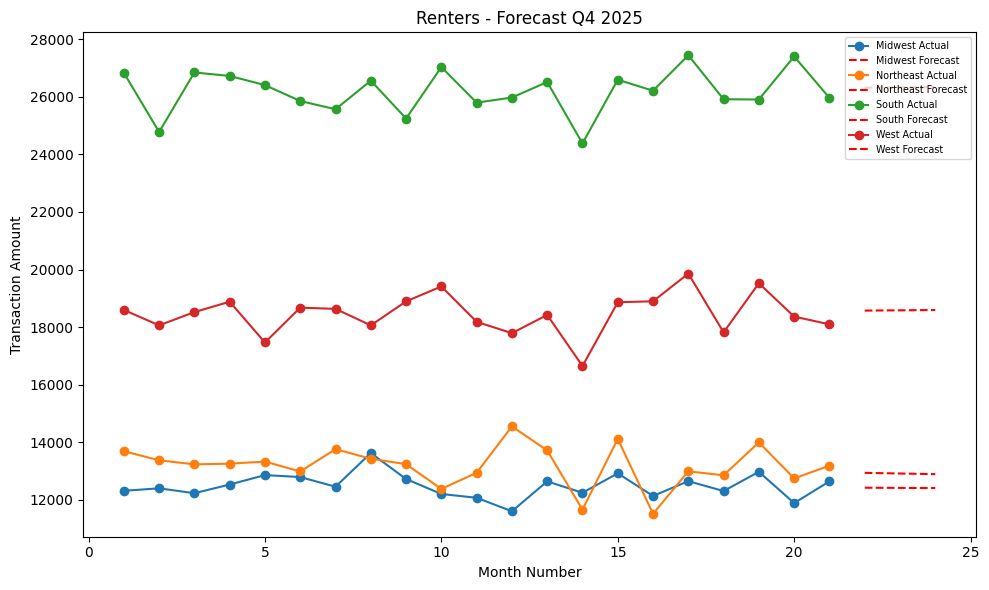

In [ ]:
products = df_product['product_type'].unique()

for i in products:
    df_filter = df_product[df_product['product_type'] == i]
    
    plt.figure(figsize=(10, 6))
   
    for region, group in df_filter.groupby('region'):
        plt.plot(group['month_index'], group['amount'], label=f"{region} Actual", marker='o')
        plt.title(f"{i} - Forecast Q4 2025")
    
    
        X_future = np.array([22, 23, 24])
        y_future = best_model.fit(group['month_index'].values.reshape(-1,1), 
                                            group['amount']).predict(X_future.reshape(-1,1))
            
        plt.plot(X_future, y_future, 'r--', label=f"{region} Forecast")
  
    plt.xlabel("Month Number")
    plt.ylabel("Transaction Amount")
    plt.legend(fontsize='x-small')
    plt.tight_layout()
    plt.show()   